**HOMEWORK**  

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```



In [2]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-17 09:18:52--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1,4M) [text/plain]
Saving to: 'housing.csv'

     0K .......... .......... .......... .......... ..........  3% 1,19M 1s
    50K .......... .......... .......... .......... ..........  7% 3,29M 1s
   100K .......... .......... .......... .......... .......... 10% 1,47M 1s
   150K .......... .......... .......... .......... .......... 14% 6,39M 1s
   200K .......... .......... .......... .......... .......... 17% 2,28M 1s
   250K .......... .......... .......... .......... .......... 21% 4,06M 0s
   300K .......... .......... .......... .......... .......... 25% 4,06M 0s
   350K .......... .......... ..

In [3]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot:ylabel='Frequency'>

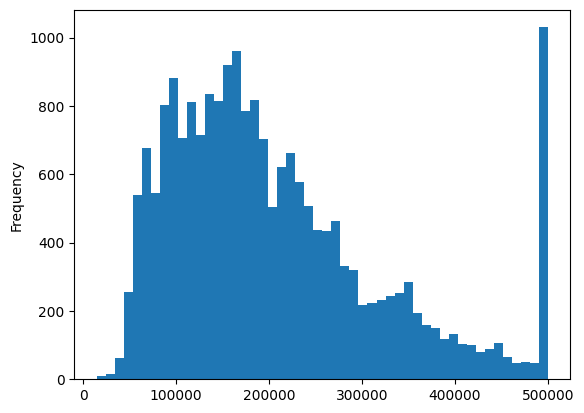

In [9]:
df.median_house_value.plot(kind='hist', bins=50)

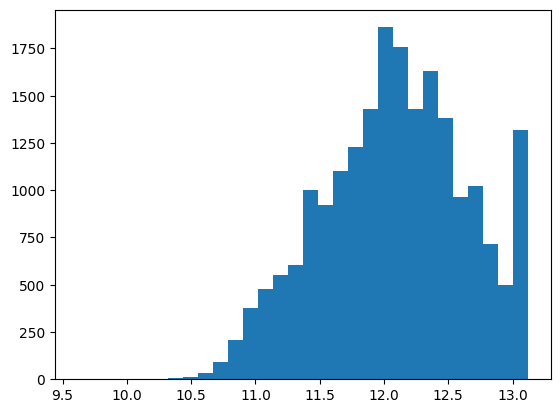

In [14]:
plt.hist(np.log1p(df.median_house_value), bins=30);

In [5]:
df_X = df.drop('median_house_value', axis=1)
y = np.log1p(df.median_house_value)

In [8]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
df_full_train, df_test, y_full_train, y_test = train_test_split(df_X, y, test_size=0.2, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [9]:
y_test

0       12.779876
1       11.166215
2       12.343227
3       11.630717
4       12.325636
          ...    
4123    11.130215
4124    12.323860
4125    12.765691
4126    12.334030
4127    11.861474
Name: median_house_value, Length: 4128, dtype: float64

- We will use `DictVectorizer` to turn train and validation into matrices.

In [16]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
dv = DictVectorizer(sparse=False)
df_train_dicts = df_train.to_dict(orient='records')
df_val_dicts = df_val.to_dict(orient='records')
df_test_dicts = df_test.to_dict(orient='records')
X_train = dv.fit_transform(df_train_dicts)
X_val = dv.transform(df_val_dicts)
X_test = dv.transform(df_test_dicts)

**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [17]:
#@ TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [18]:
#@ INSPECTION:
export_text(dt, feature_names=list(dv.get_feature_names_out()))

'|--- ocean_proximity=INLAND <= 0.50\n|   |--- value: [12.31]\n|--- ocean_proximity=INLAND >  0.50\n|   |--- value: [11.61]\n'

- Which feature is used for splitting the data?

- Answer: ocean_proximity=INLAND

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [19]:
#@ TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [20]:
#@ CALCULATING MEAN SQUARED ERROR:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred)).round(2)

0.25

- What's the RMSE of this model on validation?

- Answer:0.25

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [21]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(n, rmse)
    scores.append((n, rmse))

10 0.2457383433183843
20 0.23926159143162362
30 0.23571658024242997
40 0.23458299288526632
50 0.23310354554874654
60 0.2328429808263216
70 0.232384046270577
80 0.2325270885881096
90 0.2322152441944244
100 0.23196833981101553
110 0.2315183513876384
120 0.23162059722289455
130 0.2317096161887402
140 0.23169246809784286
150 0.23169445775520764
160 0.2316972116152682
170 0.23162910205851625
180 0.2317902360719715
190 0.23176241418109447
200 0.23165006514034595


<AxesSubplot:xlabel='n_estimators'>

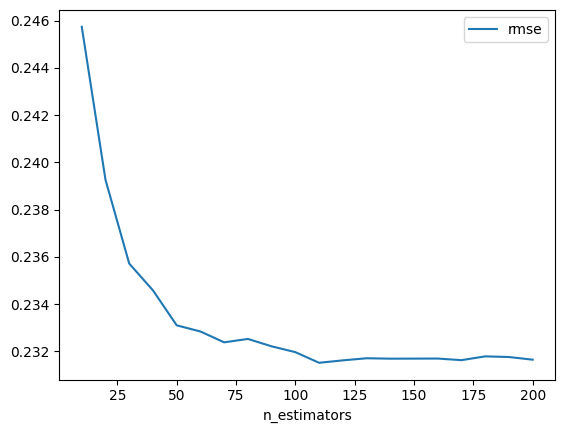

In [22]:
#@ INSPECTING THE RMSE SCORES:
df_rf_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_rf_scores.plot(x='n_estimators', y='rmse')


In [23]:
df_rf_scores.iloc[df_rf_scores['rmse'].idxmin()]

n_estimators    110.000000
rmse              0.231518
Name: 10, dtype: float64

- After which value of `n_estimators` does RMSE stop improving?

- Answer: 110

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [24]:
#@ TRAINING THE MODEL WITH DEPTH:
scores_d_n = []
for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(max_depth=d, n_estimators=n, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        scores_d_n.append((d, n, rmse))
        print(d, n, rmse)

10 10 0.25504160871076226
10 20 0.2527843628111254
10 30 0.25164651106868285
10 40 0.2510617356366555
10 50 0.2501924996109377
10 60 0.25009613605670555
10 70 0.24991662218794553
10 80 0.24959018682670703
10 90 0.24931387548986406
10 100 0.24915438732328005
10 110 0.24890494450291387
10 120 0.2489692787772818
10 130 0.2490994489918707
10 140 0.24920575579859985
10 150 0.2491914362442353
10 160 0.24911488721352457
10 170 0.2489002280044784
10 180 0.24900930356623044
10 190 0.24908309742304938
10 200 0.24910554094143506
15 10 0.24479009739308974
15 20 0.23930647684326958
15 30 0.23690899332310014
15 40 0.23598320832282838
15 50 0.23472976205475557
15 60 0.23465620779540475
15 70 0.23410614449955464
15 80 0.23396237196709047
15 90 0.23377586377559467
15 100 0.23353976973246615
15 110 0.23316836533579854
15 120 0.2332170924991897
15 130 0.2333099687153176
15 140 0.23325447197960603
15 150 0.23319835806483816
15 160 0.23314363473022764
15 170 0.23311174668233933
15 180 0.2332367209924553
15

In [25]:
df_rf_scores_d_n = pd.DataFrame(scores_d_n, columns=['max_depth', 'n_estimators', 'rmse'])

<AxesSubplot:xlabel='n_estimators', ylabel='rmse'>

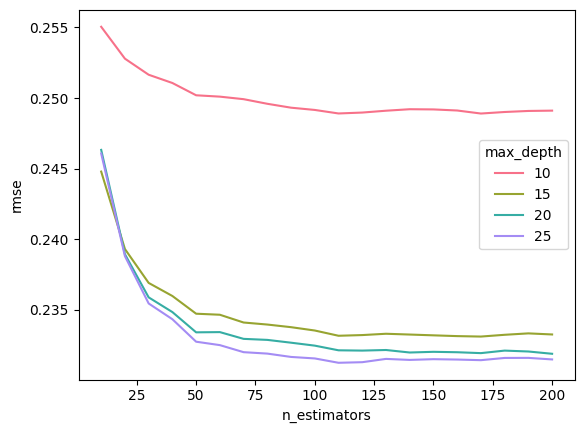

In [26]:
sns.lineplot(data=df_rf_scores_d_n, x='n_estimators', y='rmse', hue='max_depth', palette=sns.color_palette('husl', 4))

- What's the best `max_depth`:

- Answer: 25

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [27]:
#@ TRAINING THE RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [28]:
rf.feature_importances_

array([1.69573183e-02, 3.30938997e-02, 1.01333971e-01, 9.62649876e-02,
       3.62912907e-01, 3.00723750e-03, 3.10900842e-01, 3.56806263e-04,
       4.48661972e-04, 4.22762446e-03, 3.09180197e-02, 1.90412562e-02,
       2.05364687e-02])

<AxesSubplot:>

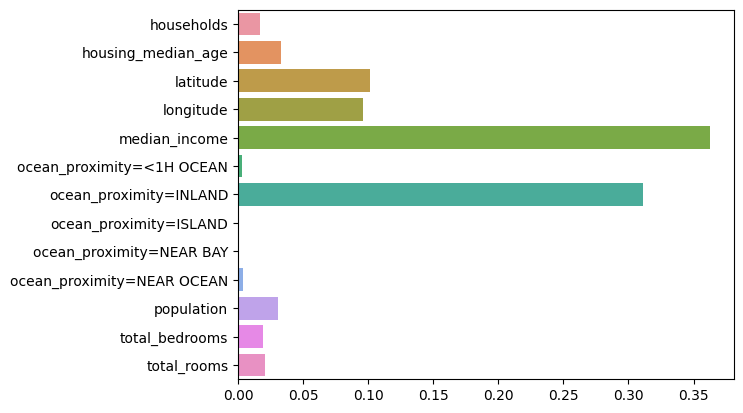

In [29]:
sns.barplot(y=list(dv.get_feature_names_out()), x=rf.feature_importances_)

- What's the most important feature?

- Answer: median_income

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [30]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [49]:
xgb_scores = {}
columns = ['iter', 'train_auc', 'val_auc']
watchlist = [(dtrain, 'train'), (dval, 'val')]

for eta in [0.01, 0.1, 0.3]:
    xgb_params = {  
        'eta': eta,  
        'max_depth': 6,  
        'min_child_weight': 1,  
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    evals_result = {}
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=100,
        verbose_eval=5,
        evals=watchlist,
        evals_result=evals_result,
    )
    train_aucs = list(evals_result['train'].values())[0]
    val_aucs = list(evals_result['val'].values())[0]

    df_scores = pd.DataFrame(
        list(zip(
            range(1, len(train_aucs)),
            train_aucs,
            val_aucs
        )), columns=columns)
    key = f"eta={xgb_params['eta']}"
    xgb_scores[key]=df_scores
    

[0]	train-rmse:11.48634	val-rmse:11.49225
[5]	train-rmse:10.92424	val-rmse:10.93003
[10]	train-rmse:10.38969	val-rmse:10.39532
[15]	train-rmse:9.88136	val-rmse:9.88695
[20]	train-rmse:9.39796	val-rmse:9.40346
[25]	train-rmse:8.93827	val-rmse:8.94370
[30]	train-rmse:8.50110	val-rmse:8.50645
[35]	train-rmse:8.08539	val-rmse:8.09064
[40]	train-rmse:7.69008	val-rmse:7.69524
[45]	train-rmse:7.31418	val-rmse:7.31924
[50]	train-rmse:6.95672	val-rmse:6.96171
[55]	train-rmse:6.61681	val-rmse:6.62173
[60]	train-rmse:6.29360	val-rmse:6.29841
[65]	train-rmse:5.98625	val-rmse:5.99094
[70]	train-rmse:5.69400	val-rmse:5.69854
[75]	train-rmse:5.41611	val-rmse:5.42053
[80]	train-rmse:5.15187	val-rmse:5.15621
[85]	train-rmse:4.90062	val-rmse:4.90486
[90]	train-rmse:4.66171	val-rmse:4.66589
[95]	train-rmse:4.43456	val-rmse:4.43868
[99]	train-rmse:4.26092	val-rmse:4.26496
[0]	train-rmse:10.44372	val-rmse:10.44938
[5]	train-rmse:6.17513	val-rmse:6.17987
[10]	train-rmse:3.65741	val-rmse:3.66135
[15]	train-r

In [50]:
xgb_scores.keys()

dict_keys(['eta=0.01', 'eta=0.1', 'eta=0.3'])

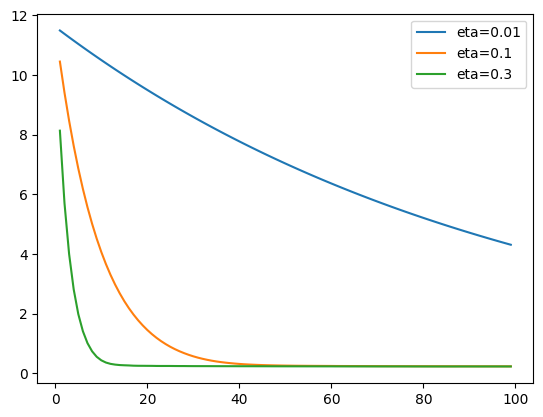

In [52]:
for key, df_score in xgb_scores.items():
    plt.plot(df_score.iter, df_score.val_auc, label=key)
plt.legend()

- Now, change eta first to 0.1 and then to 0.01.

- Which eta leads to the best RMSE score on the validation dataset?

- Answer: 0.3